# Investigating the non-linear phase readout


In [17]:
import scipy.constants as cont
import numpy as np
from scipy.fft import fft, fftfreq
from scipy import signal as sig

import copy
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from fticr_toolkit import ame
from fticr_toolkit import ideal_trap_physics as ideal
from fticr_toolkit import systematics as sys_fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def myfft(signal, fcenter=20000, window=True, zeroT=10, SAMPLING_RATE=192e3):
    # window func
    if window:
        window = sig.windows.tukey(len(signal), 0.5)
        window = sig.windows.hanning(len(signal))
        wsignal = window*signal
    else:
        wsignal = signal

    # zero padding
    zero_t = zeroT - len(wsignal)/SAMPLING_RATE
    if zero_t > 0:
        fsignal = np.append(wsignal, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )
    else:
        fsignal = wsignal

    # FFT    
    
    # Number of samples 
    N = len(fsignal)

    # FFT
    yf = fft(fsignal)
    xf = fftfreq(N, 1 / SAMPLING_RATE)

    # get index positions and amplitudes
    #idx_conv = int(np.where(xf-fcenter == 0)[0])

    idx_axial = (np.abs(xf-faxial)).argmin()
    print('pos axial', idx_axial, xf[idx_axial], np.abs( yf[idx_axial]) )

    span = 500 

    x_axial = xf[np.where(np.abs(xf-faxial) < span/2)]
    y_axial = yf[np.where(np.abs(xf-faxial) < span/2)]
    plt.plot(x_axial, np.abs(y_axial))
    plt.yscale("log")
    #plt.ylim([1e6, 1e12])
    plt.vlines([faxial], 1e3, 1e12, colors='r', linestyles='dashed')
    plt.show()

    plt.plot(x_axial, np.angle(y_axial))
    #plt.yscale("log")
    plt.ylim([0, 2*np.pi])
    #plt.vlines([faxial], 1e3, 1e12, colors='r', linestyles='dashed')
    plt.show()


In [ ]:
# The signal without anything else

SAMPLING_RATE = 192000 
FFT_window = 100e-3
faxial = 20000

t=np.arange(0, FFT_window, 1/SAMPLING_RATE) # length of conversion pulse
signal=np.sin(2*np.pi*t*faxial) # signal data (basically time domain data)
normalized_signal = np.int16((signal / signal.max()) * 32767)
plt.plot(t[:50],normalized_signal[:50])
plt.title('first 500 sampling points of the (longer) pulse')
plt.show()

In [ ]:
# just FFT of signal:

myfft(normalized_signal, fcenter=20000, window=False, zeroT=0, SAMPLING_RATE=192e3)

pos axial 200000 20000.0 314556861.8199331


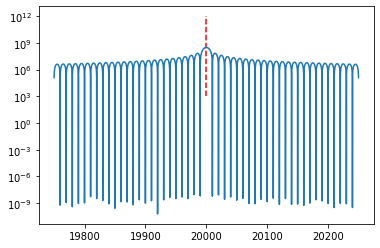

In [6]:
# just add zero padding for better resolution and check fft

zero_t = 10 - FFT_window
fsignal = np.append(normalized_signal, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

# or not
#signal = normalized_signal

# Number of samples 
N = len(fsignal)

# FFT
yf = fft(fsignal)
xf = fftfreq(N, 1 / SAMPLING_RATE)

# get index positions and amplitudes
#idx_conv = int(np.where(xf-fcenter == 0)[0])

idx_axial = (np.abs(xf-faxial)).argmin()
print('pos axial', idx_axial, xf[idx_axial], np.abs( yf[idx_axial]) )

span = 500 

x_axial = xf[np.where(abs(xf-faxial) < span/2)]
y_axial = yf[np.where(abs(xf-faxial) < span/2)]
plt.plot(x_axial, np.abs(y_axial))
plt.yscale("log")
#plt.ylim([1e6, 1e12])
plt.vlines([faxial], 1e3, 1e12, colors='r', linestyles='dashed')
plt.show()

#Whats the gain by resonator?

pos axial 200000 20000.0 235905358.985245


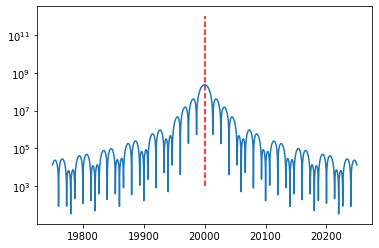

In [13]:
# zero padding and hanning -> FFT
window = sig.windows.tukey(len(signal), 0.5)
wsignal = window*normalized_signal

zero_t = 10 - FFT_window
fsignal = np.append(wsignal, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

# Number of samples 
N = len(fsignal)

# FFT
yf = fft(fsignal)
xf = fftfreq(N, 1 / SAMPLING_RATE)

# get index positions and amplitudes
#idx_conv = int(np.where(xf-fcenter == 0)[0])

idx_axial = (np.abs(xf-faxial)).argmin()
print('pos axial', idx_axial, xf[idx_axial], np.abs( yf[idx_axial]) )

span = 500 

x_axial = xf[np.where(abs(xf-faxial) < span/2)]
y_axial = yf[np.where(abs(xf-faxial) < span/2)]
plt.plot(x_axial, np.abs(y_axial))
plt.yscale("log")
#plt.ylim([1e6, 1e12])
plt.vlines([faxial], 1e3, 1e12, colors='r', linestyles='dashed')
plt.show()

#Whats the gain by resonator?

## What else could be the reason?

### The function generator: Trigger delay jitter / periodic offset

period length in ns 60.24096385542168
l period length in ns 1428.5714285714287
ns/° 0.16733601070950468 *4 0.6693440428380187
0.0 0.07000000576954335


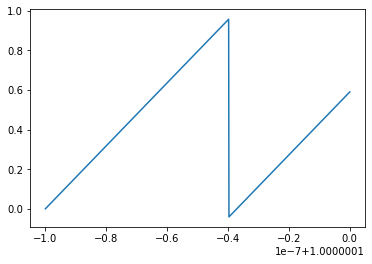

1001 1001 10 1010


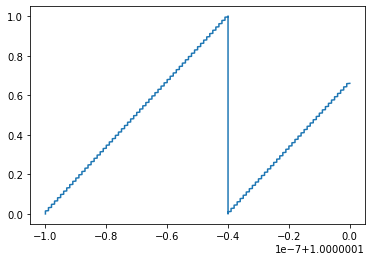

In [5]:
sampling_rate = 660e6 # samples per second
trigger_delay_resolution = 1e-9 # 4 ns

fcenter = 16.6e6 # 
tperiod = 1/fcenter
PAT_resolution = 1e-10
print('period length in ns', tperiod*1e9)
local = 700e3
lperiod = 1/local
print('l period length in ns', lperiod*1e9)

# how many nano seconds per degree?
print('ns/°', tperiod*1e9/360, '*4', tperiod*1e9*4/360)

time = np.arange(1.0, 1.0+1e-7, PAT_resolution) # 100ns in 1ns steps
ion_phase = (time*fcenter - (time*fcenter).astype('int32'))
local_phase = (time*local - (time*local).astype('int32'))
print(local_phase.min(), local_phase.max())
plt.plot(time, ion_phase-local_phase)
plt.show()

repeat = int(trigger_delay_resolution / PAT_resolution)
trigger_times = np.repeat(np.arange(1.0, 1.0+1e-7, trigger_delay_resolution), repeat) # 4ns steps (RF 33600 series)
print(len(time), len(ion_phase), repeat, len(trigger_times))
plt.plot(trigger_times[:len(ion_phase)], ion_phase)
plt.show()

### Mixer and fft:

In [6]:
LO = 700e3
RF = 730e3
fcenter = RF-LO
SAMPLING_RATE = 1000e6 # samples per second
SAMPLING_RATE_SOUNDCARD = 192000
print(1/SAMPLING_RATE, 1/SAMPLING_RATE_SOUNDCARD, SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)

aLO = 10
aRF = 1
length = 10e-3
t=np.arange(0,length,1/SAMPLING_RATE) # sampling rate of the LO!!! not of the soundcard!
sLO=aLO*np.sin(2*np.pi*t*LO) # signal data (basically time domain data)

zero_t = 0.05 - length

1e-09 5.208333333333333e-06 5208.333333333333


5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200


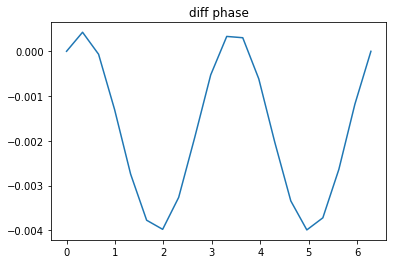

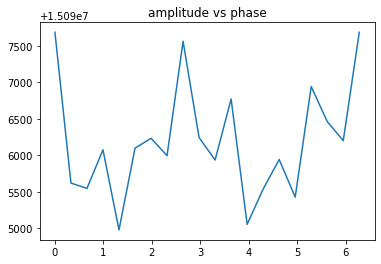

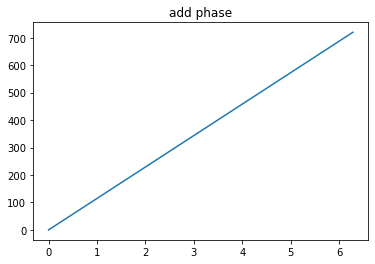

In [7]:
phases = np.linspace(0, 2*np.pi, 20)
read_phase = []
read_amp = []
for phase in phases:
    pRF = phase # phase offset
    sRF=aRF*np.sin(2*np.pi*t*RF+pRF) # signal data (basically time domain data)
    
    # mixing & normalizing
    sMI = sRF*sLO
    
    #plt.plot(t[:10000], sMI[:10000])
    #plt.show()
    sMI = np.int16((sMI / sMI.max()) * 32767)

    # zero padding
    signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )
    
    # resampling with slower soundcard:
    old_N = len(signal)
    # ether picking the samples
    #signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]
    
    # or mean the sub arrays
    sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
    mean_size = int(sampling_ratio)
    over_cut = old_N%mean_size
    print(sampling_ratio, mean_size, over_cut)
    if over_cut != 0:
        signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
    else:
        signal = np.mean(signal.reshape(-1, mean_size), axis=1)

        
    #plt.plot(signal[:100])
    #plt.show()
    
    # Number of samples 
    N = len(signal)
    #print('original N', old_N, 'down sampled', N)

    # Fourier transform
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where to look
    idx_conv = (np.abs(xf - fcenter)).argmin()
    #print(idx_conv, xf[idx_conv])
    
    # get phase
    rp = np.angle(yf[idx_conv])
    if rp < 0:
        rp +=2*np.pi
    #print('rfphase', phase, 'fft phase', rp)
    read_phase.append( rp )
    read_amp.append( np.abs(yf[idx_conv]) )

#plt.plot(read_phase)
#plt.show()
read_phase = np.unwrap(read_phase)
#plt.plot(read_phase)
#plt.show()
read_phase -= read_phase.min()
#plt.plot(read_phase)
#plt.show()
diff_phase = phases - read_phase
plt.plot(phases, diff_phase/2/np.pi*360)
plt.title("diff phase")
plt.show()
plt.plot(phases, read_amp)
plt.title("amplitude vs phase")
plt.show()

add_phase = phases + read_phase
add_phase -= add_phase.min()
plt.plot(phases, add_phase/2/np.pi*360)
plt.title("add phase")
plt.show()

## resonator excitation due to coupling pulse and **just** the underlying signal (no axial excitation)

1 0.05623413251903491
rfphase 0.0 fft phase 0.07345355746288434 fft amp 15723394.55266967
rfphase 0.3306939635357677 fft phase 0.3888632700250256 fft amp 15725023.634750433
rfphase 0.6613879270715354 fft phase 0.7023236137827324 fft amp 15725864.922893886
rfphase 0.992081890607303 fft phase 1.015465162369579 fft amp 15725816.690732233
rfphase 1.3227758541430708 fft phase 1.3299384433528254 fft amp 15725029.713288927
rfphase 1.6534698176788385 fft phase 1.6473310184953982 fft amp 15724015.045093125
rfphase 1.984163781214606 fft phase 1.9690555535059375 fft amp 15723075.721044127
rfphase 2.3148577447503738 fft phase 2.2962248726879833 fft amp 15720747.32327823
rfphase 2.6455517082861415 fft phase 2.6294809307941707 fft amp 15721055.539699584
rfphase 2.9762456718219092 fft phase 2.9688371386031895 fft amp 15721896.306806121
rfphase 3.306939635357677 fft phase 3.313534920267826 fft amp 15725011.85612974
rfphase 3.6376335988934447 fft phase 3.6620397264685183 fft amp 15725180.441086465
rfph

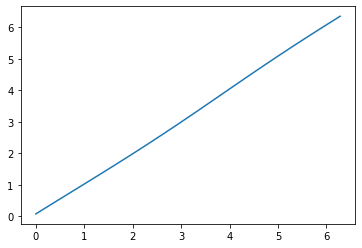

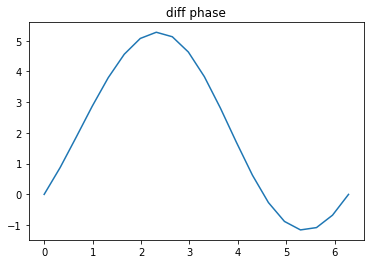

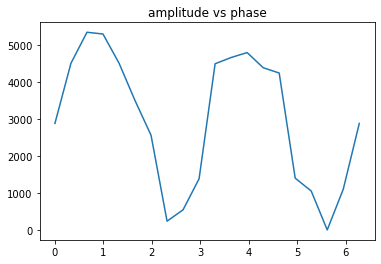

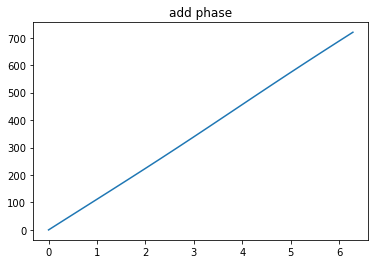

In [51]:
phases = np.linspace(0, 2*np.pi, 20)
read_phase = []
read_amp = []

dbRES = -25
aRES = aRF*10**(dbRES/20)
print(aRF, aRES)
sRES=aRES*np.sin( 2*np.pi*t*RF+130/360*2 )

for phase in phases:
    pRF = phase # phase offset
    sRF=aRF*np.sin(2*np.pi*t*RF+pRF) # signal data (basically time domain data)
    #plt.plot(t[:10000], sRF[:10000])

    # adding resonator signal
    sADDED = sRF + sRES
    #plt.plot(t[:10000], sRF[:10000])
    #plt.show()
    
    # mixing & normalizing
    sMI = sADDED*sLO
    
    sMI = np.int16((sMI / sMI.max()) * 32767)

    # zero padding
    signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )
    
    # resampling with slower soundcard:
    old_N = len(signal)
    # ether picking the samples
    signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]
    
    # or mean the sub arrays
    sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
    mean_size = int(sampling_ratio)
    over_cut = old_N%mean_size
    #print(sampling_ratio, mean_size, over_cut)
    #if over_cut != 0:
    #    signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
    #else:
    #    signal = np.mean(signal.reshape(-1, mean_size), axis=1)

        
    #plt.plot(signal[:100])
    #plt.show()
    
    # Number of samples 
    N = len(signal)
    #print('original N', old_N, 'down sampled', N)

    # Fourier transform
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where to look
    idx_conv = (np.abs(xf - fcenter)).argmin()
    #print(idx_conv, xf[idx_conv])
    
    # get phase
    rp = np.angle(yf[idx_conv])
    if rp < 0:
        rp +=2*np.pi
    amp = np.abs( yf[idx_conv] )
    print('rfphase', phase, 'fft phase', rp, "fft amp", amp )
    read_phase.append( rp )
    read_amp.append( amp )

#plt.plot( read_phase )
#plt.show()
read_phase = np.unwrap( read_phase )
plt.plot(phases, read_phase)
plt.show()
read_phase -= read_phase.min()
#plt.plot(read_phase)
#plt.show()
diff_phase = phases - read_phase
plt.plot(phases, diff_phase/2/np.pi*360)
plt.title("diff phase")
plt.show()

# normalize amp
read_amp -= np.min(read_amp)
plt.plot(phases, read_amp)
plt.title("amplitude vs phase")
plt.show()

add_phase = phases + read_phase
add_phase -= add_phase.min()
plt.plot(phases, add_phase/2/np.pi*360)
plt.title("add phase")
plt.show()

### Thats it?

This could be it. This is an underlying signal due to excitation of the resonator. 

#### But it is not (kind of):
We tested this and the resonator signal relaxes ultra fast. In combination with our fft_delay of 5 ms (waiting after the coupling pulse before we start acquiring the signal) the resonator signal is long gone. How did we test it? We increased the fft delay step by step up to 100 milliseconds and checked how the non-linear phase effect changes. If it would be the underlying signal of the resonator, which is definitly at some rate relaxing, the amplitude of this non linear phase effect would have to decrease. That was not the case. This supports the idea that the real phase of the ion is effected, either radially or axially.

#### Still:
Since we see this excitation of the resonator (with a fixed phase due to the phase of the coupling pulse) it might be possible that its still in some way the origin, e.g. by exciting the axial motion. If this is the case the axial phase will be effected directly at the time of the coupling and the effect will not change with longer fft delay. So that would fit. So how do we test that? Two possibilities: off resonant measurement, which might be less effected by the resonator signal or **shaping the pulse** (like Sven suggested) with a **window function** to reduce the amplitude of the slopes (see FFT) and theirby not excite the resonator. **This was successfully tested and the theory correct!**


## Another prospect due to this:

Since the axial frequency modifies the phase on readout, we can also check the jitter of the phase readout due to a random phase in the axial mode:

What we see when executig the cells below is that with routhly -16dB axial signal with a random phase we get the phase jitter of 7/8 degree we typically see.

**What we also see**
If we somehow fix this phase, e.g. by an axial excitation just before the coupling, we would go down to sub degree stability even with a SNR of just -5 db.
**AMAZING**

154.1453998499853 96.1318140630268


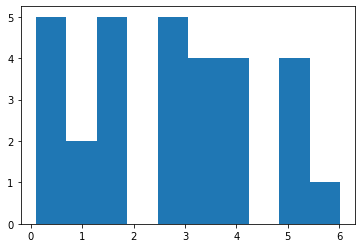

In [76]:
axial_phases = np.random.rand(30)*2*np.pi
#axial_phases = np.random.rand(30)*2*np.pi/180 # make it stable to 2 degree by axial excitation just before the coupling.
print(np.mean(axial_phases)*180/np.pi, np.std(axial_phases)*180/np.pi)
plt.hist(axial_phases)
plt.show()

1 0.7079457843841379 0.7079457843841379
rfphase 3.5998483120229556 fft phase 5.611823080707632 fft amp 15721103.161242167
rfphase 3.974323675389692 fft phase 5.535350666758287 fft amp 15720377.345807731
rfphase 1.6244190468824877 fft phase 0.6714156298769364 fft amp 15726173.660449374
rfphase 2.9420853092494035 fft phase 0.4675493962469876 fft amp 15724513.142076796
rfphase 2.8709875673548724 fft phase 0.5748000828295307 fft amp 15726497.188270647
rfphase 1.5098129055103582 fft phase 0.6331153974398492 fft amp 15725384.024136228
rfphase 3.4969572862503595 fft phase 5.688677907862633 fft amp 15721760.463327285
rfphase 0.09655492399098643 fft phase 0.0778137776186122 fft amp 15723919.672606764
rfphase 4.034717118694459 fft phase 5.539582196424263 fft amp 15720519.570563879
rfphase 6.020594270140105 fft phase 6.212257688907657 fft amp 15722086.219727399
rfphase 5.011704267608332 fft phase 5.8106778952125575 fft amp 15720759.66199709
rfphase 0.8900195764558121 fft phase 0.4014107951838864 

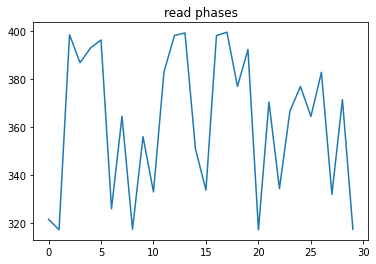

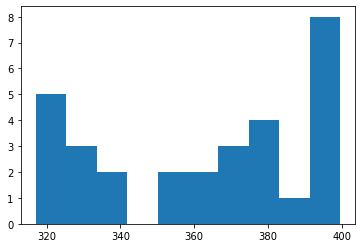

-3 362.49071574755254 29.619118668212735
1 0.5011872336272722 0.5011872336272722
rfphase 3.5998483120229556 fft phase 5.9380620032540445 fft amp 15720993.684830504
rfphase 3.974323675389692 fft phase 5.810851807150544 fft amp 15720777.699292906
rfphase 1.6244190468824877 fft phase 0.5127560560457364 fft amp 15724749.218421543
rfphase 2.9420853092494035 fft phase 0.2306075677693999 fft amp 15723819.34451145
rfphase 2.8709875673548724 fft phase 0.29132478638476406 fft amp 15723969.27260213
rfphase 1.5098129055103582 fft phase 0.4896752486230692 fft amp 15725972.365994543
rfphase 3.4969572862503595 fft phase 6.003152726701631 fft amp 15722537.206926601
rfphase 0.09655492399098643 fft phase 0.07002355776837932 fft amp 15723074.198522719
rfphase 4.034717118694459 fft phase 5.803311924465872 fft amp 15720658.553007381
rfphase 6.020594270140105 fft phase 6.233533696623664 fft amp 15723724.439776972
rfphase 5.011704267608332 fft phase 5.925642822104624 fft amp 15721653.487693198
rfphase 0.8900

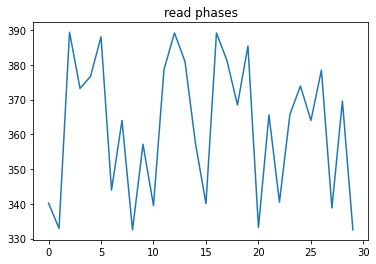

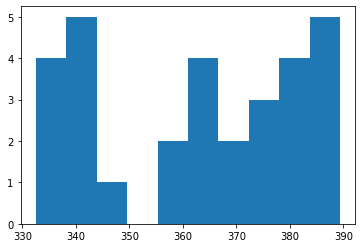

-6 362.35425870219655 19.655513381627667
1 0.31622776601683794 0.31622776601683794
rfphase 3.5998483120229556 fft phase 6.128117847234313 fft amp 15722008.169818861
rfphase 3.974323675389692 fft phase 6.032093409402608 fft amp 15721292.537407102
rfphase 1.6244190468824877 fft phase 0.34858650340117064 fft amp 15725448.894589141
rfphase 2.9420853092494035 fft phase 0.12837371799366631 fft amp 15724765.476818176
rfphase 2.8709875673548724 fft phase 0.15878453634048884 fft amp 15723484.27440702
rfphase 1.5098129055103582 fft phase 0.33808703707384025 fft amp 15724279.864138018
rfphase 3.4969572862503595 fft phase 6.165835776370723 fft amp 15721853.727694895
rfphase 0.09655492399098643 fft phase 0.06098239851990101 fft amp 15722663.748029537
rfphase 4.034717118694459 fft phase 6.022829045303375 fft amp 15721383.605028948
rfphase 6.020594270140105 fft phase 6.258179619737532 fft amp 15722358.91071381
rfphase 5.011704267608332 fft phase 6.05129026339166 fft amp 15723203.690189382
rfphase 0.8

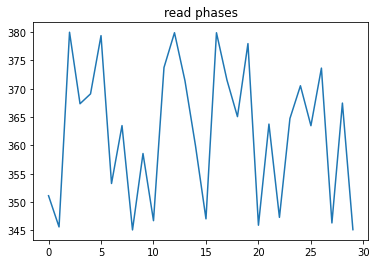

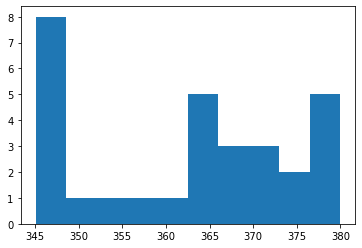

-10 362.48077563243976 12.110786669883353
1 0.15848931924611134 0.15848931924611134
rfphase 3.5998483120229556 fft phase 6.239430361011319 fft amp 15722935.286872165
rfphase 3.974323675389692 fft phase 6.190478552978433 fft amp 15723246.84215594
rfphase 1.6244190468824877 fft phase 0.19607755843278252 fft amp 15723338.06635116
rfphase 2.9420853092494035 fft phase 0.07496899652121505 fft amp 15723588.652384179
rfphase 2.8709875673548724 fft phase 0.08776124397297165 fft amp 15723924.11813909
rfphase 1.5098129055103582 fft phase 0.19321479606959444 fft amp 15723339.894387385
rfphase 3.4969572862503595 fft phase 6.256304439096981 fft amp 15722283.522715503
rfphase 0.09655492399098643 fft phase 0.05099516791344935 fft amp 15722974.224369511
rfphase 4.034717118694459 fft phase 6.184731597652887 fft amp 15723569.578604938
rfphase 6.020594270140105 fft phase 0.0021307622916366 fft amp 15723052.90747253
rfphase 5.011704267608332 fft phase 6.177288344885208 fft amp 15722636.388861697
rfphase 0.

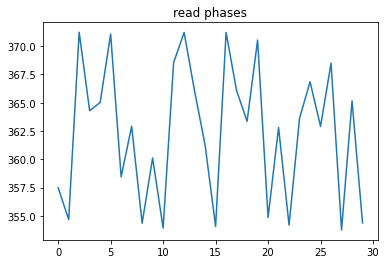

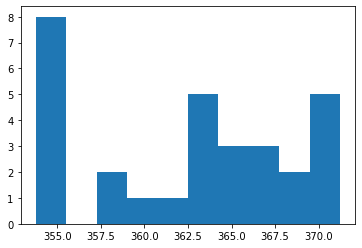

-16 362.43419148134075 6.03364412051557
1 0.1 0.1
rfphase 3.5998483120229556 fft phase 6.272422595640735 fft amp 15723636.21630083
rfphase 3.974323675389692 fft phase 6.241830117098663 fft amp 15722764.219143195
rfphase 1.6244190468824877 fft phase 0.1378574878777315 fft amp 15723602.703588862
rfphase 2.9420853092494035 fft phase 0.05976734907092681 fft amp 15722688.75241192
rfphase 2.8709875673548724 fft phase 0.067372779495518 fft amp 15722953.034192843
rfphase 1.5098129055103582 fft phase 0.1366852461180362 fft amp 15723713.548880003
rfphase 3.4969572862503595 fft phase 6.2826073574511385 fft amp 15723392.20029056
rfphase 0.09655492399098643 fft phase 0.04656622111762873 fft amp 15723319.785871198
rfphase 4.034717118694459 fft phase 6.238055588165877 fft amp 15723072.896326117
rfphase 6.020594270140105 fft phase 0.01412977609298439 fft amp 15722436.936054977
rfphase 5.011704267608332 fft phase 6.228425834509186 fft amp 15723603.500272963
rfphase 0.8900195764558121 fft phase 0.110776

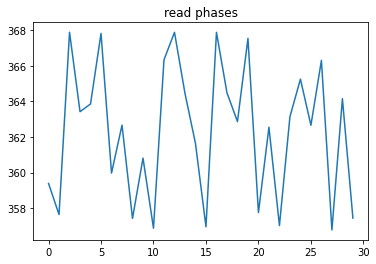

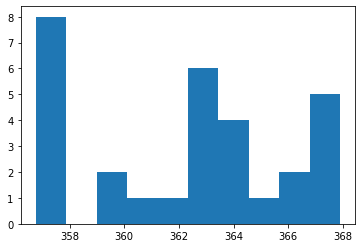

-20 362.3620300027405 3.806631581156374
1 3.1622776601683795e-05 3.1622776601683795e-05
rfphase 3.5998483120229556 fft phase 0.037783697375067996 fft amp 15724447.896170318
rfphase 3.974323675389692 fft phase 0.03777467335757679 fft amp 15724441.050585296
rfphase 1.6244190468824877 fft phase 0.03782994100864508 fft amp 15724452.331964951
rfphase 2.9420853092494035 fft phase 0.037803829666970754 fft amp 15724451.565756408
rfphase 2.8709875673548724 fft phase 0.03780567931277375 fft amp 15724450.428217381
rfphase 1.5098129055103582 fft phase 0.03782994100864508 fft amp 15724452.331964951
rfphase 3.4969572862503595 fft phase 0.03778693211393742 fft amp 15724458.719465965
rfphase 0.09655492399098643 fft phase 0.03780088666474936 fft amp 15724449.995784769
rfphase 4.034717118694459 fft phase 0.037773533881223356 fft amp 15724446.056808265
rfphase 6.020594270140105 fft phase 0.037789806363751274 fft amp 15724457.83950867
rfphase 5.011704267608332 fft phase 0.0377679543760977 fft amp 15724451

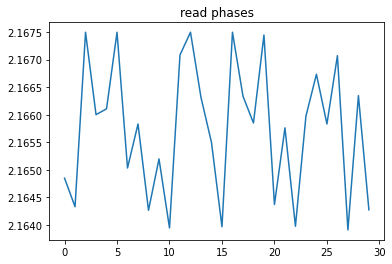

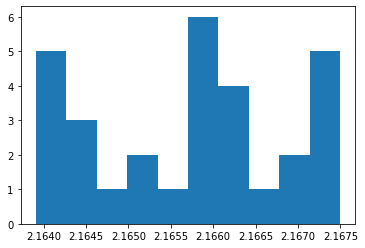

-90 2.165741978039518 0.0012088881944797545


In [82]:
dblist = [-3, -6, -10, -16, -20, -90]

mean_phases = []
std_phases = []

for db in dblist:

    dbAXIAL = db
    aAXIAL = aRF*10**(dbAXIAL/20)
    print(aRF, aAXIAL, aAXIAL/aRF)

    sRF=aRF*np.sin(2*np.pi*t*RF) # signal data (basically time domain data)

    read_phase = []
    read_amp = []

    for phase in axial_phases:
        sAXIAL=aAXIAL*np.sin( 2*np.pi*t*RF + phase)
        #plt.plot(t[:10000], sRF[:10000])

        # adding resonator signal
        sADDED = sRF + sAXIAL
        #plt.plot(t[:10000], sRF[:10000])
        #plt.show()

        # mixing & normalizing
        sMI = sADDED*sLO

        sMI = np.int16((sMI / sMI.max()) * 32767)

        # zero padding
        signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

        # resampling with slower soundcard:
        old_N = len(signal)
        # ether picking the samples
        signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]

        # or mean the sub arrays
        sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
        mean_size = int(sampling_ratio)
        over_cut = old_N%mean_size
        #print(sampling_ratio, mean_size, over_cut)
        #if over_cut != 0:
        #    signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
        #else:
        #    signal = np.mean(signal.reshape(-1, mean_size), axis=1)


        #plt.plot(signal[:100])
        #plt.show()

        # Number of samples 
        N = len(signal)
        #print('original N', old_N, 'down sampled', N)

        # Fourier transform
        yf = fft(signal)
        xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

        # where to look
        idx_conv = (np.abs(xf - fcenter)).argmin()
        #print(idx_conv, xf[idx_conv])

        # get phase
        rp = np.angle(yf[idx_conv])
        if rp < 0:
            rp +=2*np.pi
        amp = np.abs( yf[idx_conv] )
        print('rfphase', phase, 'fft phase', rp, "fft amp", amp )
        read_phase.append( rp )
        read_amp.append( amp )

    read_phase = np.unwrap( read_phase ) * 180/np.pi
    plt.title("read phases")
    plt.plot(read_phase)
    plt.show()

    plt.hist(read_phase)
    plt.show()
    mean = np.mean(read_phase)
    std = np.std(read_phase)
    print(db, mean, std)
    mean_phases.append(mean)
    std_phases.append(std)
    


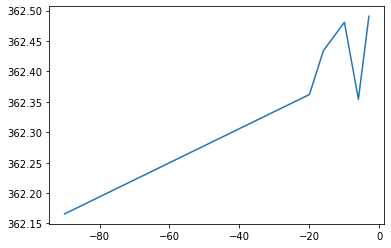

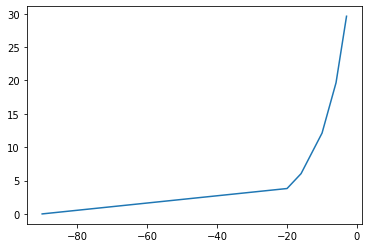

In [83]:


plt.plot(dblist, np.unwrap(np.asarray(mean_phases)/180*np.pi)*180/np.pi)
plt.show()
plt.plot(dblist, std_phases)
plt.show()

## What happens if I have a periodic waiting time (accumulation time) error?

First: How can this happen? If you transfere your waiting time to anouther unit, being samples of the function generator, where you have not only a time-quantization due to the sampling rate (500 MSa/s -> 2 ns/Sample) but maybe also programming limitations, like a minimal size for a arbitrary signal segment of 12 samples -> 24 ns (given by the function generator) or in the arbitrary script itself some rounding/conversion errors in that case.

Lets assume we do our non-linearity check measurement: We find a few PATs (in ms steps oor higher so we can ignore the local oszillator) with which we span the 2pi range for the current ions frequency / phase readout. Then we want to see either a flat line of phase - phase residuals or the discussed sinusoidial effekt. But what if we have PAT errors? How does the data look like and can we by accident create a sinusoidial like result?

frequency 25070660.855


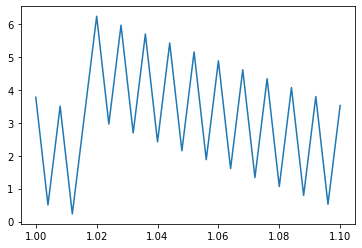

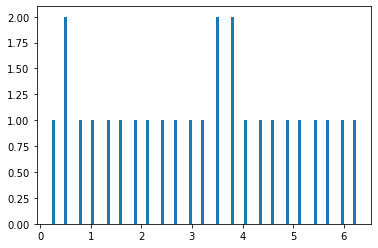

In [9]:
# lets prepare the PATs like we would for a measurement, but also later much much more for easier check...
RF_SAMPLE_RATE = 500e6
MAX_SEQ_COUNT = int(1e6) 
MIN_SEQ_MEMORY_POINTS = int(32)

freq = fcyclotron
freq = 25070660.855
print("frequency", freq)
PATs = np.arange(1,1.1,0.004)
#PATs = np.arange(1,1.1,2e-9)
phases = ( freq * PATs ) % (2*np.pi)
plt.plot(PATs, phases)
plt.show()
plt.hist(phases, 100)
plt.show()

In [10]:
# convert PATs to samples and back:
def time_to_samples(time):
    return np.round(RF_SAMPLE_RATE * time).astype('int')

def time_to_segment(time)
    samples = time_to_samples(time)
    segments = []
    
    for these_samples in samples:
        if these_samples / MAX_SEQ_COUNT < MIN_SEQ_MEMORY_POINTS:
            while True:
                segment_repetition = total_samples / min_segment_size
                if round(segment_repetition,9) % 1 !=0: #check if the number is integer
                    min_segment_size += 1
                    continue
                else:
                    wait_pulse = (int(min_segment_size), int(segment_repetition))
                break
        else:
            while True:
                samples_in_segment = total_samples / segment_repetition
                if round(samples_in_segment,9) % 1 !=0: #check if the number is integer
                    segment_repetition -= 10 #ideally it should be -=1, but it seems to be working with 10, saving the computational time
                    continue
                else:
                    wait_pulse = (int(samples_in_segment), int(segment_repetition))
                break
        segments.append(wait_pulse)
    return segments
        
def samples_to_time(samples):
    return np.round(samples / RF_SAMPLE_RATE,9)

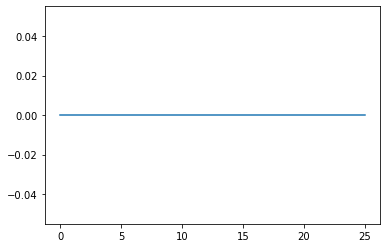

In [11]:
PATSa = time_to_samples(PATs)
diff_PATs = samples_to_time(PATSa) - PATs
plt.plot(diff_PATs)

### So, the conversion is fine for ms steps

But for 4e-6 s steps it becomes a 1e-12 seconds error (which is very wierd) and for 4e-9 / 2e-9 s steps it becomes a 1e-9 seconds error (please try it out)

frequency 25070660.845


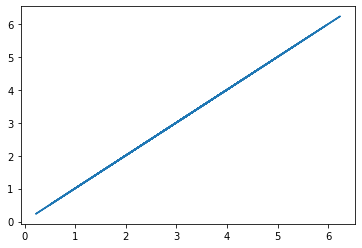

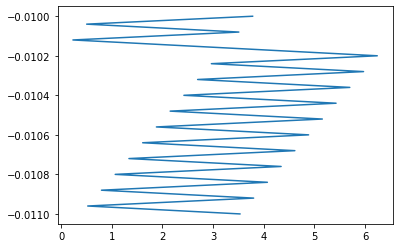

In [20]:
# lets prepare the PATs like we would for a measurement, but also later much much more for easier check...

mfreq = freq - 0.01
print("frequency", mfreq)
mphases = ( mfreq * PATs ) % (2*np.pi)
plt.plot(mphases, phases)
plt.show()
plt.plot(phases, mphases-phases)
plt.show()

## Window functions for pulses:

In order to keep the same power, windowed pulses have to be adjusted in length. The results below show that the tukey window need smallest scaling/time increase and e.g. flattop a really big one. Since the Axial peak on the resonator has a limited life time (except feedback is used), the flattop gehts beaten by it.

RF 20000000.0 LO 20010000.0 f_sideband 10000.0 SR 200000000.0 pi time 0.016
no window 0.016
amp ratio 1.0
flattop 0.07392
amp ratio 1.0034589295684944
hann 0.032
amp ratio 0.9609206605890315
('tukey', 0.5) 0.02136
amp ratio 0.9924009927788016


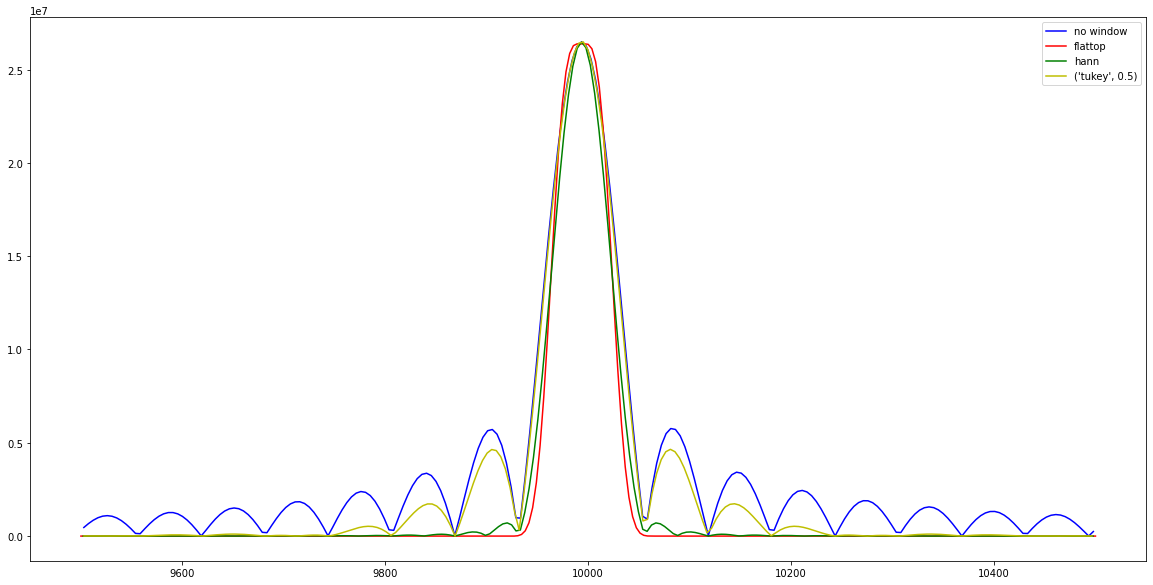

In [197]:
from scipy.signal import windows
plt.rcParams["figure.figsize"] = (20,10)

RF = 20e6
LO = 20.01e6
f_sideband = LO - RF
SR = 200e6
pi_time = 16e-3
print("RF", RF, "LO", LO, "f_sideband", f_sideband, "SR", SR, "pi time", pi_time)

window_types = [["no window", 1], [("hamming"), 1], [("blackman"), 1], [("hann"), 1], [("tukey", 0.5), 1], [("flattop"), 1]]
window_types = [["no window", 1], [("hann"), 2.13], [("tukey", 0.5), 1.335], [("flattop"), 4.62]]
window_types = [["no window", 1], [("flattop"), 4.62], [("hann"), 2.0],  [("tukey", 0.5), 1.335]]
#window_types = [[("flattop"), 4.62], [("tukey", 0.5), 1.335]]

no_window_amp = 0

colors = ["b-", "r-", "g-", "y-", "k-", "c-"]

for idx, setting in enumerate(window_types):
    scaling = setting[1]
    wtype = setting[0]
    
    # pulse
    pulse_length = pi_time * scaling
    t = np.linspace(0, pulse_length, int(pulse_length*SR)+1)
    pulse_original = np.sin( 2*np.pi*t*RF + 0)
    sLO = np.sin( 2*np.pi*t*LO + 0)
    print(wtype, t.max())

    # window function
    if wtype != "no window":
        window = windows.get_window(wtype, len(pulse_original), fftbins=False)
    else:
        window = np.ones(len(pulse_original))
    
    #print("integral", sum(window))
    #plt.plot(window)
    #plt.show()
    signal = pulse_original*window
    #print(pulse_windowed)

    #plt.plot(t, pulse)
    #plt.show()

    # mixing
    signal = signal*sLO
    #print(pulse)

    # normalization
    signal = np.int16((signal / pulse.max()) * 32767)

    # zero padding
    signal = np.append(signal, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

    # down_sampling
    signal = signal[::int(SR/SAMPLING_RATE_SOUNDCARD)]
    #print(signal, len(signal))
    #plt.plot(signal)
    #plt.show()

    # Fourier transform
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where
    idx_conv = (np.abs(xf - f_sideband)).argmin()

    # get phase
    span = 5e2
    indexes = np.where( abs(xf - f_sideband) < span )
    freqs = xf[indexes]
    phases = np.angle(yf[indexes])
    amps = np.abs(yf[indexes])
    
    centeramp = np.abs(yf[idx_conv])
    if wtype == "no window":
        no_window_amp = centeramp
    print("amp ratio", centeramp/no_window_amp)
    # show spec
    plt.plot(freqs, amps, colors[idx], label=wtype)
    #plt.plot(freqs, phases, colors[idx], label=wtype)

#plt.yscale('log')
plt.legend()
plt.show()